# Clase SSVEP para clasificación por picos

Funciones y clase de utilidad para el procesamiento de señales de EEG, y más concretamente en señales que contengan SSVEPs.

## Explicado

Importamos funciones de utilidad.

In [ ]:
import numpy as np
import scipy.io as sc
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
from scipy.signal import butter, filtfilt

Implemento una función que lea archivo .mat, cree un diccionario con los datos y nos devuelva la key relacionada con la señal de EEG del sujeto.

In [ ]:
def lectorMAT(ruta):
  '''
  Devuelve una matriz de cuatro dimensiones de la forma [estímulos, canales, muestras, trials]
  Hay que ingresar la ruta de donde se encuentra el archivo.mat, debe ser un string del modo 'directorio'
  '''
  Sujeto = sc.loadmat(ruta)
  Sujeto = np.array(Sujeto['eeg'], dtype='float32') #accede a la key 'eeg', convierte los datos adquiridos a una matriz de datos del tipo float32
  Sujeto = Sujeto[:,:,39:,:] #recorta los primeros 39 trial debido a que el sujeto se está preparando
  return Sujeto 

Implemento la clase SSVEP() y su constructor con los atributos necesarios. Los objetos creados mediante esta clase serán una señal única de EEG cruda.

In [ ]:
class SSVEP(): #inicio la clase SSVEP
    
    def __init__(self, ruta, sampleFrec, lowFrec, highFrec, orden, stimuli, trial, utilSamples, estimulos): #constructor
    '''
    Al crear el objeto se deben introducir algunas variables de utilidad que formarán parte de los atributos:
    -ruta: directorio donde se encuentra el archivo .mat, debe ser un string de la forma 'directorio' (copiar y pegar ruta del archivo subido a Colab y agregar comillas)
    -sampleFrec: frecuencia de muestreo del conversor AD
    -lowFrec: frecuencia de corte baja del filtro pasa banda
    -highFrec: frecuencia de corte alta del filtro pasa banda
    -orden: orden del filtro (de 1 a 6). Mientras más alto más pronunciada será la atenuación, pero consumirá más recursos del procesador.
    -stimuli: posición de la frecuencia del estimulador dentro del array en estimulos (primera dimensión de la matriz).
    -trial: número de trial del que queremos la señal de EEG.
    -utilSamples: será el número de muestras que queremos del total de la señal, sirve principalmente para aislar la parte que queremos ver del espectro en frecuencias,
    el máximo de utilSamples será el len() de la señal cruda.
    -estimulos: lista de estimulos para el clasificador de picos
    '''
      self.fm = sampleFrec
      self.Signal = lectorMAT(ruta)
      self.lFrec = lowFrec
      self.hFrec = highFrec
      self.orden = orden
      self.stimuli = stimuli
      self.trial = trial
      self.T = 1/sampleFrec
      self.samples = len(self.Signal[0][0])
      self.totalTime = self.samples/self.fm
      self.utilSamples = utilSamples
      self.Pikes = []
      self.Frecs = []
      self.points = 0
      self.listPoints = []
      self.contador = 0
      self.estimulos = estimulos
      self.accuracy = []
      self.error = 1000
      self.lastStimuli = []

Creamos un método que promediará las señales captadas por cada canal, por lo que nos quedaremos con una sola que será el promedio

In [ ]:
    def meanEEG(self):
      '''
      método que devuelve la señal promediada producto de cada canal. Por lo tanto es necesario que se respete la estructura de matriz de 4 dimensiones
      '''
      self.meanSignal = np.mean(self.Signal[self.stimuli], 0)
      return self.meanSignal

Creamos un método que nos permite graficar la trial de EEG sin acondicionar.  Voltaje en función del tiempo.

In [ ]:
    def plotRawEEG(self):
      self.signal = self.meanEEG()
      self.xAxies = np.arange(0, self.totalTime, self.T)
      plt.plot(self.xAxies, self.signal[:,self.trial])
      plt.title(f'EEG sin filtrar del trial {self.trial} estímulo {self.estimulos[self.stimuli]} Hz')
      plt.xlabel('Tiempo (s)')
      plt.ylabel('Potencia (uV)')

Método que filtra el trial y lo devuelve

In [ ]:
    def filterEEG(self):
      self.signal = self.meanEEG()
      self.frec = 0.5 * self.fm
      self.low = self.lFrec/self.frec
      self.high = self.hFrec/self.frec
      self.b, self.a = butter(self.orden, [self.low, self.high], btype='band')
      self.filterTrial = filtfilt(self.b, self.a, self.signal[:,self.trial])
      return self.filterTrial

Grafica el trial filtrado. Voltaje en función del tiempo.

In [ ]:
    def plotFilterEEG(self):
      self.filterSignal = self.filterEEG()
      self.xAxies = np.arange(0, self.totalTime, self.T)
      plt.plot(self.xAxies, self.filterSignal)
      plt.title(f'EEG filtrado del trial {self.trial} estímulo {self.estimulos[self.stimuli]} Hz')
      plt.xlabel('Tiempo (s)')
      plt.ylabel('Potencia (uV)')

Método que realiza la tranformada rapida de fourier y devuelve los coeficientes de las frecuencias y potencias correspondientes. Recorta los vectores con self.utilSamples dependiendo con que sección del espectro en frecuencias nos queremos quedar

In [ ]:
   def tranformCoeficients(self):
      self.filterSignal = self.filterEEG()
      self.spectrum = fft(self.filterSignal)
      self.frecuencias = np.arange(0, self.fm, self.fm/(len(self.signal)))
      return self.frecuencias[:self.utilSamples], self.spectrum[:self.utilSamples]

Método que grafica su espectro en frecuencias del trial.

In [ ]:
    def plotSpectrum(self):
      self.xAxies, self.yAxies = self.tranformCoeficients()
      plt.plot(self.xAxies, abs(self.yAxies))
      plt.title(f'Espectro de frecuencias del trial {self.trial} estímulo {self.estimulos[self.stimuli]} Hz')
      plt.xlabel('Frecuencia (Hz)')
      plt.ylabel('Potencia(uV)')

El método peaks() devuelve 2 listas, una con las Frecuencias donde hay máximos en el espectro de frecuencias y otra que corresponde a la potencia que tienen esos máximos.

In [ ]:
    def peaks(self):
        self.xAxies, self.filterSignal = self.tranformCoeficients() #del método tranformCoeficients() obtiene los componentes frecuenciales y de energía de la transformada rapida de fourier
        self.listSignal = list(self.filterSignal) #transformo a lista el array con los coeficientes de potencia apra recorrerlo con un for
        self.listSignal.append(1) #agrego una posicion más a la lista para que termine el for buscando máximo y a su vez recorra todos los datos
        for i in range(len(self.listSignal)): #recorre la lista con la potencia correspondiente al espectro en frecuencias y busca máximos
            if abs(self.listSignal[i+2]) ==1: #si llega al ultimo lugar de la lista termina el for
                break
            if abs(self.listSignal[i+1]) > abs(self.listSignal[i]) and abs(self.listSignal[i+1]) >= abs(self.listSignal[i+2]): #método para saber si el número que sigue es un máximo
                self.Pikes.append(abs(self.listSignal[i+1])) #agrega la parte real del componente frecuencial a una lista llamada Pikes
                self.Frecs.append(self.xAxies[i+1]) #agrega la frecuencia correspondiente a la parte real añadida a la lista Pikes
        return self.Frecs, self.Pikes

El método peakClassifier() toma el return de peaks para clasificar mediante un sistema de puntos que estímulo se está mirando. Suma un punto si algun máximo corresponde a la frecuencia del primer armónico del armónico fundamental.
Suma un punto si corresponde al segundo armónico.
Suma otro punto si corresponde dicha frecuencia al máximo absoluto en el espectro en frecuencias.

In [ ]:
    def peakClassifier(self, Incertidumbre):
      '''
      Función que clasifica dependiendo de los picos en el espectro de frecuencias del trial.
      Debe ser introducido un valor de Incertidumbre, que se utilizará para generar intervalos donde puede entrar los armónicos de n frecuencia fundamental.
      '''
        self.Frecs, self.Pikes = self.peaks() #del método self.peaks() obtiene dos listas que corresponden a su return.
        self.maximo = self.Frecs[self.Pikes.index(max(self.Pikes))] #frecuencia del máximo absoluto en el espectro de frecuencias.
        
        for i in self.Frecs: #recorre la lista de frecuencias de los picos en el espectro de frecuencias del trial.
           '''
           comentar si da menos accuracy que cuando se ve solo el máximo absoluto
           '''
           # for a in self.Frecs: #recorre la misma listas de frecuencias en los picos para buscar el primer y segundo armónico
            #    if i*2 <= a+Incertidumbre and i*2 >= a-Incertidumbre: #si esta dentro del intervalo el segundo armónico de la frecuencia i suma un punto
             #       self.points += 1
              #  if i*3 <= a+Incertidumbre and i*3 >= a-Incertidumbre: #si esta dentro del intervalo el tercer armónico de la frecuencia i suma un punto
               #     self.points += 1
            
            if i == self.maximo: #si la freuencia i es la misma que el máximo absoluto sumará un punto
                self.points += 1
            self.listPoints.append(self.points) #agrega los puntos conseguidos a la lista self.listPoints
            self.points = 0 #devuelve el contador de puntos a 0 cuando termina de analizar la frecuencia i
         
        for j in self.estimulos: #como los valores en frecuencia no son enteros haremos un método de minimizar el error que correpondera a una de las frecuencias dentro de la lista self.estimulos
            #j correspondera a un estimulo dentro de la lista
            self.contador = 0 #contador para recorrer la lista de puntos, vuelve a 0 cuando se analiza un estimulo
            for k in self.listPoints: #k para el estimulo j recorrera la lista de puntos
                if k == max(self.listPoints): #si el punto en la posición corresponde a la cantidad máxima que se pudo obtener entonces verá de que frecuencia se trata
                   self.newError = abs(j - (self.Frecs[self.contador])) #va minimizando el error y lo agrega a la variables self.newError. La cantidad de error inicial se encuentra en el contructor de la clase
                   if self.newError < self.error: #si el error es menor al que estaba anteriormente
                       self.error = self.newError #error será el nuevo error que era más pequeño
                       self.lastStimuli.append(j) #añade a una lista el estimulo que corresponda al minimo error encontrado
                       
                self.contador += 1 #suma 1 cada vez que se repite el for y cambia el k, que corresponde al puntaje obtenido
    
        print(f"La persona se encuentra mirando el estímulo de {self.lastStimuli[len(self.lastStimuli)-1]} Hz") #la ultima posición de la lista lastStimuli corresponde al estimulo que minimizó más el error
        #print(f'El máximo absoluto está en {self.maximo} Hz')
        #print(self.Frecs)
        #print(self.Pikes)
        #print(self.listPoints)

Ejemplo 1 de prueba del código. Se intentará clasificar que estimulo corresponde al estimulo 0 (9.25 Hz) trial 0 únicamente con el método de picos.

In [73]:
directorio = '/content/eeg_s8-eeg_train.mat'
fm = 256 #Hz
lfrec = 7 #Hz
hfrec = 45 #Hz
orden = 6 #orden del filtro pasa banda
stimuli = 0 #posición 0 de los estimulos, corresponde al de 9.25 Hz
trial = 0 #posición 0 de los trial
utilSamples = 200 #muestras que quiero ver en el espectro y clasificar
estimulos = [9.25, 11.25, 13.25, 9.75, 11.75, 13.75, 10.25, 12.25, 14.25, 10.75, 12.75, 14.75]
Incertidumbre = 0.2 #Hz

eeg = SSVEP(directorio, fm, lfrec, hfrec, orden, stimuli, trial, utilSamples, estimulos) #creo el objeto eeg
eeg.peakClassifier(Incertidumbre) #utilizo el método peakClassifier()

La persona se encuentra mirando el estímulo de 9.25 Hz


Ejemplo 2 de prueba del código. Si intentarán clasificar los primeros 5 trials correspondientes al estímulo de 14.75 Hz utilizando el método de los picos.

In [81]:
directorio = '/content/eeg_s8-eeg_train.mat'
fm = 256 #Hz
lfrec = 7 #Hz
hfrec = 45 #Hz
orden = 6 #orden del filtro pasa banda
stimuli = 11 #posición 0 de los estimulos, corresponde al de 9.25 Hz
#trial = 0 #posición 0 de los trial
utilSamples = 200 #muestras que quiero ver en el espectro y clasificar
estimulos = [9.25, 11.25, 13.25, 9.75, 11.75, 13.75, 10.25, 12.25, 14.25, 10.75, 12.75, 14.75]
Incertidumbre = 0.1 #Hz

for i in range(5):
  eeg = SSVEP(directorio, fm, lfrec, hfrec, orden, stimuli, i, utilSamples, estimulos) #creo el objeto eeg
  eeg.peakClassifier(Incertidumbre) #utilizo el método peakClassifier()

La persona se encuentra mirando el estímulo de 14.75 Hz
La persona se encuentra mirando el estímulo de 14.75 Hz
La persona se encuentra mirando el estímulo de 14.75 Hz
La persona se encuentra mirando el estímulo de 14.75 Hz
La persona se encuentra mirando el estímulo de 14.75 Hz


## Código entero

In [88]:
import numpy as np
import scipy.io as sc
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
from scipy.signal import butter, filtfilt

def lectorMAT(ruta):
  Sujeto = sc.loadmat(ruta)
  Sujeto = np.array(Sujeto['eeg'], dtype='float32')
  Sujeto = Sujeto[:,:,39:,:]
  return Sujeto

class SSVEP():
    
    def __init__(self, ruta, sampleFrec, lowFrec, highFrec, orden, stimuli, trial, utilSamples, estimulos):
      self.fm = sampleFrec
      self.Signal = lectorMAT(ruta)
      self.lFrec = lowFrec
      self.hFrec = highFrec
      self.orden = orden
      self.stimuli = stimuli
      self.trial = trial
      self.T = 1/sampleFrec
      self.samples = len(self.Signal[0][0])
      self.totalTime = self.samples/self.fm
      self.utilSamples = utilSamples
      self.Pikes = []
      self.Frecs = []
      self.points = 0
      self.listPoints = []
      self.contador = 0
      self.estimulos = estimulos
      self.accuracy = []
      self.error = 1000
      self.lastStimuli = []
      
    def meanEEG(self):
      self.meanSignal = np.mean(self.Signal[self.stimuli], 0)
      return self.meanSignal
        
    def plotRawEEG(self):
      self.signal = self.meanEEG()
      self.xAxies = np.arange(0, self.totalTime, self.T)
      plt.plot(self.xAxies, self.signal[:,self.trial])
      plt.title(f'EEG sin filtrar del trial {self.trial} estímulo {self.estimulos[self.stimuli]} Hz')
      plt.xlabel('Tiempo (s)')
      plt.ylabel('Potencia (uV)')

    def filterEEG(self):
      self.signal = self.meanEEG()
      self.frec = 0.5 * self.fm
      self.low = self.lFrec/self.frec
      self.high = self.hFrec/self.frec
      self.b, self.a = butter(self.orden, [self.low, self.high], btype='band')
      self.filterTrial = filtfilt(self.b, self.a, self.signal[:,self.trial])
      return self.filterTrial

    def plotFilterEEG(self):
      self.filterSignal = self.filterEEG()
      self.xAxies = np.arange(0, self.totalTime, self.T)
      plt.plot(self.xAxies, self.filterSignal)
      plt.title(f'EEG filtrado del trial {self.trial} estímulo {self.estimulos[self.stimuli]} Hz')
      plt.xlabel('Tiempo (s)')
      plt.ylabel('Potencia (uV)')

    def tranformCoeficients(self):
      self.filterSignal = self.filterEEG()
      self.spectrum = fft(self.filterSignal)
      self.frecuencias = np.arange(0, self.fm, self.fm/(len(self.signal)))
      return self.frecuencias[:self.utilSamples], self.spectrum[:self.utilSamples]

    def plotSpectrum(self):
      self.xAxies, self.yAxies = self.tranformCoeficients()
      plt.plot(self.xAxies, abs(self.yAxies))
      plt.title(f'Espectro de frecuencias del trial {self.trial} estímulo {self.estimulos[self.stimuli]} Hz')
      plt.xlabel('Frecuencia (Hz)')
      plt.ylabel('Potencia(uV)')
      
    def peaks(self):
        self.xAxies, self.filterSignal = self.tranformCoeficients()
        self.listSignal = list(self.filterSignal)
        self.listSignal.append(1)
        for i in range(len(self.listSignal)): #codigo para detecta maximos sobre umbrales
            if abs(self.listSignal[i+2]) ==1:
                break
            if abs(self.listSignal[i+1]) > abs(self.listSignal[i]) and abs(self.listSignal[i+1]) >= abs(self.listSignal[i+2]):
                self.Pikes.append(abs(self.listSignal[i+1]))
                self.Frecs.append(self.xAxies[i+1])
        # print(f"hay un máximo en {self.Frecs[self.Pikes.index(max(self.Pikes))]}")
        # print(self.Frecs)
        return self.Frecs, self.Pikes
        
    def peakClassifier(self, Incertidumbre):
        self.Frecs, self.Pikes = self.peaks()
        self.maximo = self.Frecs[self.Pikes.index(max(self.Pikes))]
        
        for i in self.Frecs:
          
           #for a in self.Frecs:
            #    if i*2 <= a+Incertidumbre and i*2 >= a-Incertidumbre:
             #       self.points += 1
              #  if i*3 <= a+Incertidumbre and i*3 >= a-Incertidumbre:
               #     self.points += 1
            
            if i == self.maximo:
                self.points += 1
            self.listPoints.append(self.points)
            self.points = 0
         
        for j in self.estimulos:
            self.contador = 0
            for k in self.listPoints:
                if k == max(self.listPoints):
                   self.newError = abs(j - (self.Frecs[self.contador]))
                   if self.newError < self.error: #minimiza el error
                       self.error = self.newError
                       self.lastStimuli.append(j)
                       
                self.contador += 1
    
        print(f"La persona se encuentra mirando el estímulo de {self.lastStimuli[len(self.lastStimuli)-1]} Hz")
        #print(f'El máximo absoluto está en {self.maximo} Hz')
        #print(self.Frecs)
        #print(self.Pikes)
        #print(self.listPoints)

In [89]:
directorio = '/content/eeg_s8-eeg_train.mat'
fm = 256
lfrec = 7
hfrec = 45
orden = 6
stimuli = 0
#trial = 14
utilSamples = 200
estimulos = [9.25, 11.25, 13.25, 9.75, 11.75, 13.75, 10.25, 12.25, 14.25, 10.75, 12.75, 14.75]

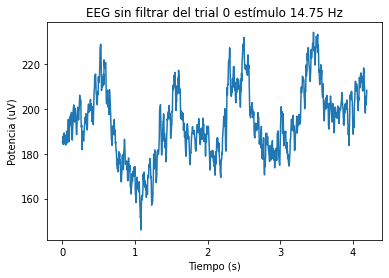

In [90]:
eeg = SSVEP(directorio, fm, lfrec, hfrec, orden, 11, 0, utilSamples, estimulos)
eeg.plotRawEEG()

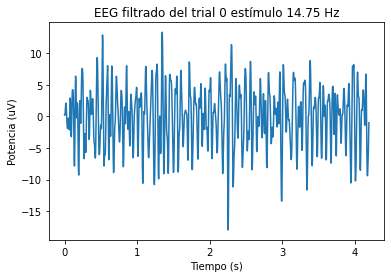

In [91]:
eeg.plotFilterEEG()

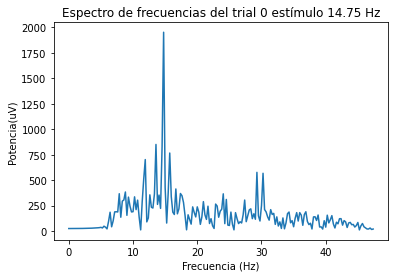

In [92]:
eeg.plotSpectrum()

In [86]:
for k in range(5):
    eeg = SSVEP(directorio, fm, lfrec, hfrec, orden, stimuli, k, utilSamples, estimulos)
    eeg.peakClassifier(0.1)

La persona se encuentra mirando el estímulo de 14.75 Hz
La persona se encuentra mirando el estímulo de 14.75 Hz
La persona se encuentra mirando el estímulo de 14.75 Hz
La persona se encuentra mirando el estímulo de 14.75 Hz
La persona se encuentra mirando el estímulo de 14.75 Hz
